# Bitcoin Price Prediction

Bitcoin is a decentralised digital currency that has been gaining traction over the past few years. The value of Bitcoin is not directly tied to economic policies, making it difficult to predict and explain. This project aims to predict the price of Bitcoin through time series analysis with SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors), and LSTM RNN (Long-Short Term Memory Recurrent Neural Network).

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
# importing data
df = pd.read_csv('BTC.csv')

df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df_2021_06 = df.iloc[-30:] # data for the month of Jun 2021
df = df.iloc[:-30] # data from Jan 2016 to May 2021

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900.0
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600.0
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800.0
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500.0
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600.0


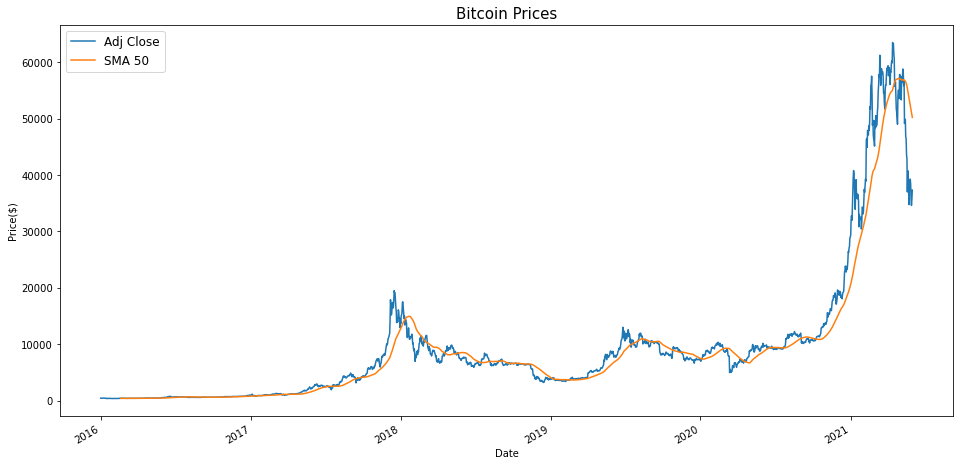

In [3]:
# visualising bitcoin prices
df['Adj Close'].plot(figsize=(16,8))
df['Adj Close'].rolling(50).mean().plot(label='SMA 50')
plt.title('Bitcoin Prices', fontsize=15)
plt.ylabel('Price($)')
plt.xlabel('Date')
plt.legend(fontsize=12)

### Time Series Analysis and Forecasting using SARIMAX

SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is a time series analysis and forecasting method that handles data with trend and seasonality.

C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

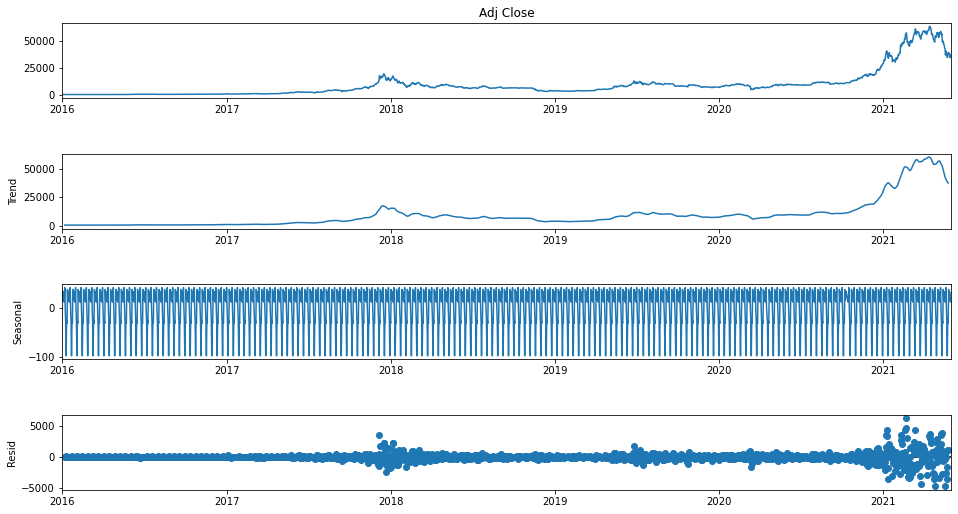

In [4]:
# decomposing model into trend, seasonality and residuals
decomposition = seasonal_decompose(df['Adj Close'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [5]:
# function to print adfuller test results  
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    print('\n')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis: Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis: Time series has a unit root, indicating it is non-stationary")

In [6]:
# checking stationarity of timeseries data
adf_check(df['Adj Close'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.8722877382725955
p-value : 0.7969614445310448
#Lags Used : 26
Number of Observations Used : 1947


Weak evidence against null hypothesis: Time series has a unit root, indicating it is non-stationary


In [7]:
# differencing non-stationary timeseries data
df['Adj Close First Difference'] = df['Adj Close'] - df['Adj Close'].shift(1)
df['Adj Close First Difference'].head()

Date
2016-01-01         NaN
2016-01-02   -0.896027
2016-01-03   -3.427002
2016-01-04    3.080017
2016-01-05   -1.131012
Name: Adj Close First Difference, dtype: float64

In [8]:
# checking stationarity of first-order differenced timeseries data
adf_check(df['Adj Close First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.663339508663249
p-value : 4.785598018232849e-09
#Lags Used : 26
Number of Observations Used : 1946


Strong evidence against the null hypothesis: Data has no unit root and is stationary


<AxesSubplot:xlabel='Date'>

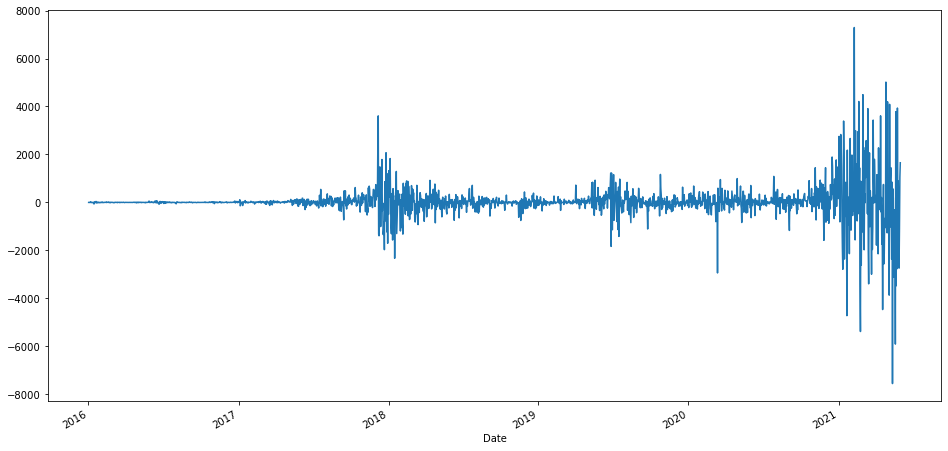

In [9]:
# plotting first-order differenced timeseries data
df['Adj Close First Difference'].plot(figsize=(16,8))
# white noise-like pattern concludes it is indeed stationary

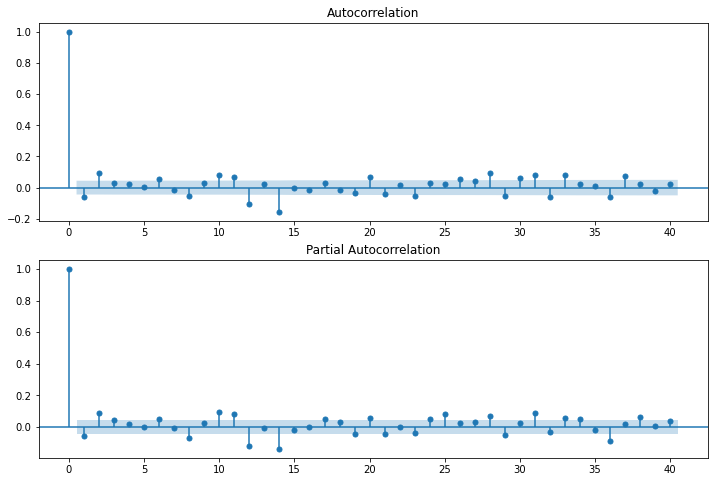

In [10]:
# plotting autocorrelation and partial autocorrelation plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Adj Close First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Adj Close First Difference'].iloc[13:], lags=40, ax=ax2)
# the plots show no sign of autoregression or moving average

In [11]:
# creating SARIMAX model
model = sm.tsa.statespace.SARIMAX(df['Adj Close'], order=(0,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                 1974
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood              -16346.296
Date:                            Thu, 29 Jul 2021   AIC                          32694.591
Time:                                    02:46:14   BIC                          32700.173
Sample:                                         0   HQIC                         32696.643
                                           - 1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.011e+06   7138.545    141.687      0.000    9.97e+05    1.03e+06
Ljung-Box (L1) (Q):                

C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
# predicting forecasted prices
fc = pd.Series(results.forecast(30, alpha=0.05))
fc.index = pd.Series(pd.date_range(start = df.index[-1], periods=30+1, freq='D')[1:])
fc.head()

C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2021-06-01    41113.152344
2021-06-02    37635.105469
2021-06-03    37867.046876
2021-06-04    35100.996094
2021-06-05    39036.394532
Name: predicted_mean, dtype: float64

In [13]:
# confidence intervals of predicted forecast
n = len(df)
prediction = results.get_prediction(start=n+1, end=n+30)
prediction_ci = prediction.conf_int()
prediction_ci.index = pd.Series(pd.date_range(start = df.index[-1], periods=30+1, freq='D')[1:])
print(prediction_ci.head())

            lower Adj Close  upper Adj Close
2021-06-01     34847.493956     40422.716982
2021-06-02     34452.933973     41281.159779
2021-06-03     31158.718086     39043.274102
2021-06-04     34628.793726     43443.995338
2021-06-05     33904.351947     43560.921491


C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


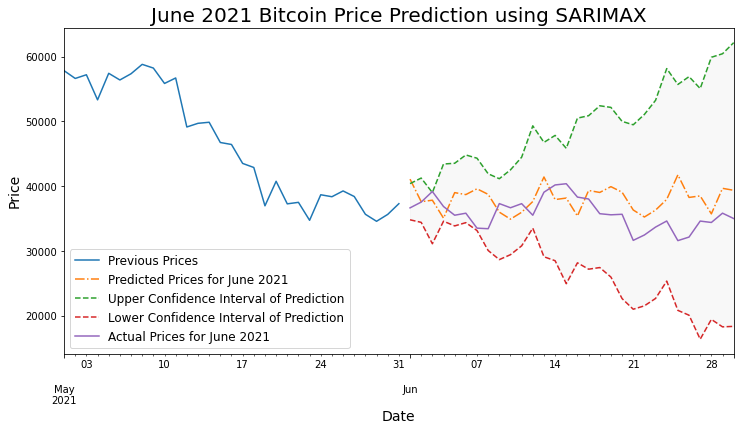

In [14]:
# visual plot of predicted forecast prices
plt.figure(figsize=(12, 6))

ax = df.iloc[1943:]['Adj Close'].plot(label='Previous Prices')
fc.plot(ax=ax, style='-.', label='Predicted Prices for June 2021')
prediction_ci['upper Adj Close'].plot(ax=ax, style='--', label='Upper Confidence Interval of Prediction')
prediction_ci['lower Adj Close'].plot(ax=ax, style='--', label='Lower Confidence Interval of Prediction')
df_2021_06['Adj Close'].plot(ax=ax, label='Actual Prices for June 2021')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci, color='grey', alpha=0.05)

ax.set_xlabel('Date', size=14)
ax.set_ylabel('Price', size=14)
ax.legend(fontsize=12)
ax.set_title('June 2021 Bitcoin Price Prediction using SARIMAX', size=20)

plt.show()

In [15]:
# evaluation of prediction with rmse
rmse = math.sqrt(mean_squared_error(df_2021_06['Adj Close'], fc))
print(rmse)

3766.8151668461423


### Price Prediction using LSTM RNN

LSTM RNN (Long-Short Term Memory Recurrent Neural Network) is a deep learning method used to store and process past data in sequential order to predict future data.

In [16]:
# assigning dataset to training and test values
dataset_train = df.iloc[:, 4:5]
training_set = dataset_train.values

dataset_test = df_2021_06.iloc[:, 4:5]
real_stock_price = dataset_test.values

In [17]:
# feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [18]:
# creating training data to fit the model
X_train = []
y_train = []

# creating a data structure with 100 timesteps and 1 output. 1974 is the total number of records in the Adj Close column.
for i in range(100, 1974):
    X_train.append(training_set_scaled[i-100:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data into 3-dimensional array since RNN only accepts 3-dimensional shape data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
# initialising the RNN
regressor = Sequential()

# adding the first LSTM layer and some dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# adding a second LSTM layer and some dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a third LSTM layer and some dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a fourth LSTM layer and some dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [20]:
# compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
# fitting the RNN to the training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
59/59 [==============================] - 5s 85ms/step - loss: 0.0087
Epoch 2/100
59/59 [==============================] - 5s 85ms/step - loss: 0.0025
Epoch 3/100
59/59 [==============================] - 5s 86ms/step - loss: 0.0022
Epoch 4/100
59/59 [==============================] - 5s 82ms/step - loss: 0.0021
Epoch 5/100
59/59 [==============================] - 6s 108ms/step - loss: 0.0023
Epoch 6/100
59/59 [==============================] - 6s 105ms/step - loss: 0.0024
Epoch 7/100
59/59 [==============================] - 6s 103ms/step - loss: 0.0019
Epoch 8/100
59/59 [==============================] - 5s 86ms/step - loss: 0.0020
Epoch 9/100
59/59 [==============================] - 5s 81ms/step - loss: 0.0020
Epoch 10/100
59/59 [==============================] - 5s 79ms/step - loss: 0.0019
Epoch 11/100
59/59 [==============================] - 5s 79ms/step - loss: 0.0018
Epoch 12/100
59/59 [==============================] - 5s 79ms/step - loss: 0.0016
Epoch 13/100
59/59 [==

Epoch 96/100
59/59 [==============================] - 6s 96ms/step - loss: 5.6308e-04: 1s
Epoch 97/100
59/59 [==============================] - 6s 95ms/step - loss: 6.2817e-04
Epoch 98/100
59/59 [==============================] - 6s 98ms/step - loss: 5.2373e-04
Epoch 99/100
59/59 [==============================] - 6s 97ms/step - loss: 5.2967e-04
Epoch 100/100
59/59 [==============================] - 5s 90ms/step - loss: 6.2825e-04


In [22]:
# creating test data to fit the model
dataset_total = pd.concat((dataset_train['Adj Close'], dataset_test['Adj Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 100:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(100, inputs.shape[0]):
    X_test.append(inputs[i-100:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
# predicting prices of test data
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.Series(np.reshape(predicted_stock_price, (1,-1))[0])
predicted_stock_price.index = dataset_test.index
print(predicted_stock_price)

Date
2021-06-01    36652.253906
2021-06-02    37190.484375
2021-06-03    37879.484375
2021-06-04    38932.093750
2021-06-05    39114.835938
2021-06-06    38337.578125
2021-06-07    37397.546875
2021-06-08    35991.312500
2021-06-09    34612.054688
2021-06-10    34700.976562
2021-06-11    35427.406250
2021-06-12    36280.722656
2021-06-13    36307.742188
2021-06-14    36970.335938
2021-06-15    38238.535156
2021-06-16    39437.152344
2021-06-17    39510.261719
2021-06-18    38951.734375
2021-06-19    37638.613281
2021-06-20    36280.257812
2021-06-21    35319.675781
2021-06-22    33684.402344
2021-06-23    32235.384766
2021-06-24    31663.335938
2021-06-25    32050.693359
2021-06-26    31927.773438
2021-06-27    31602.406250
2021-06-28    32067.763672
2021-06-29    32905.882812
2021-06-30    34112.808594
dtype: float32


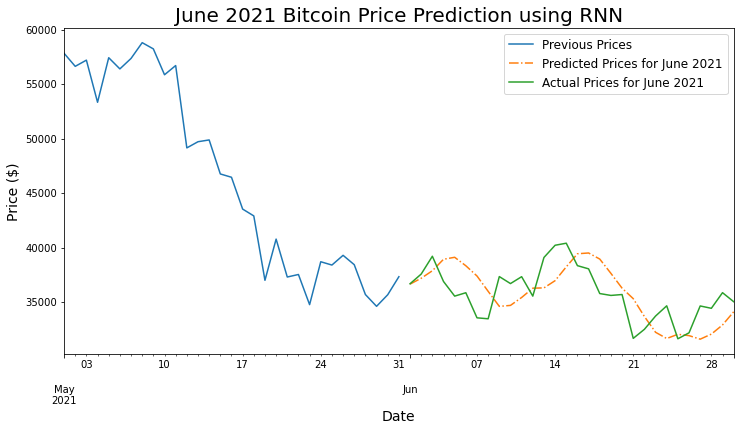

In [24]:
# visual plot of predicted forecast prices
plt.figure(figsize=(12, 6))

ax = df.iloc[1943:]['Adj Close'].plot(label='Previous Prices')
predicted_stock_price.plot(ax=ax, style='-.', label = 'Predicted Prices for June 2021')
dataset_test['Adj Close'].plot(ax=ax, label = 'Actual Prices for June 2021')

ax.set_title('June 2021 Bitcoin Price Prediction using RNN', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Price ($)', size=14)
plt.legend(fontsize=12)
plt.show()

In [25]:
# evaluation of prediction with rmse
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(rmse)

2258.4068509911317


The LSTM RNN model appears to perform better than the SARIMAX model, based on the plots and the lower RMSE (Root Mean Squared Error) value. As such, the LSTM RNN model should be adopted for forecasting Bitcoin prices in the short run. However, due to the high volatility of Bitcoin prices, both models are not likely to produce accurate predictions in the long run.